# Telecom: Solution Code

As part of this project, I follow the steps I illustrated in the work plan. I begin by preprocessing the data (converting data types, addressing null values, and merging the datasets together) then explore a few EDA questions to better understand the dataset. Next, I prepare the data for modeling by dropping unnecessary columns, deriving new ones, scaling numerical values, and encoding categorical values. I test four models (Logistic Regression, Random Forest, LightGBM, and CatBoost) and use GridSearch for hyperparameter tuning. LightGBM resulted in the highest AUC-ROC on the test set.

## Data Initialization

First, I will load the libraries needed for EDA and the corresponding datasets.

There are four datasets:
* `contract.csv` - contract information
* `personal.csv` - the client's personal data
* `internet.csv` - information about Internet services
* `phone.csv` - information about telephone services

Each dataset contains a `customerID` column that is unique for each client.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer, get_scorer_names

# for analyzing results
import eli5


In [2]:
# load data
contract = pd.read_csv('/datasets/final_provider/contract.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

# contract = pd.read_csv('contract.csv')
# internet = pd.read_csv('internet.csv')
# personal = pd.read_csv('personal.csv')
# phone = pd.read_csv('phone.csv')

## Data Preprocessing
I start by observing each individual dataset. Many data types (ie dates and floats) need to be converted, and there are many columns with Yes/No values that I can turn into 1/0 values. After cleaning, I merge the datasets and address the null values. Null values indicate the customer did not subscribe to a particular service.

### Individual Data Sets

#### Contract
For the contract data set, I convert the columns to snake case, update the data type of `total_charges`, binarize the `paperless_billing` column, and create the target variable (`has_ended`).

In [3]:
# view data
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
# view info
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
# change column names to snake case
contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
                    'payment_method', 'monthly_charges', 'total_charges']

# update data types
contract['total_charges'] = contract['total_charges'].replace(' ', 0).astype(float)

In [6]:
# binarize paperless_billing column
contract['paperless_billing'] = np.where(contract['paperless_billing'] == 'Yes', 1, 0)

In [7]:
# create has_ended target
contract['has_ended'] = np.where(contract['end_date'] != 'No', 1, 0)

In [8]:
# view new data
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,has_ended
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65,1


#### Internet

In [9]:
# view data
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [10]:
# view info
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
# update column names 
internet.columns = ['customer_id', 'internet_type', 'internet_security', 'internet_backup',
                    'internet_device_protection', 'internet_tech_support', 'internet_tv',
                    'internet_movies']

In [12]:
# binarize columns
for col in internet.columns[2:]:
    internet[col] = np.where(internet[col] == 'Yes', 1, 0)

In [13]:
internet.head()

,customer_id,internet_type,internet_security,internet_backup,internet_device_protection,internet_tech_support,internet_tv,internet_movies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0


#### Personal

In [14]:
# view data
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [15]:
# view data
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [16]:
# update column names
personal.columns = ['customer_id', 'gender', 'is_senior_citizen',
                    'has_partner', 'has_dependents']

# binarize columns
for col in personal.columns[3:]:
    personal[col] = np.where(personal[col] == 'Yes', 1, 0)

In [17]:
personal.head()

,customer_id,gender,is_senior_citizen,has_partner,has_dependents
0,7590-VHVEG,Female,0,1,0
1,5575-GNVDE,Male,0,0,0
2,3668-QPYBK,Male,0,0,0
3,7795-CFOCW,Male,0,0,0
4,9237-HQITU,Female,0,0,0


#### Phone

In [18]:
# view data
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [19]:
# view info
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [20]:
# update column names
phone.columns = ['customer_id', 'has_multiple_lines']

# binarize columns
phone['has_multiple_lines'] = np.where(phone['has_multiple_lines'] == 'Yes', 1, 0)

In [21]:
phone.head()

,customer_id,has_multiple_lines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1


### Merge Datasets

In [22]:
# merge contract + internet data
df = contract.merge(internet, on='customer_id', how='left')

# merge in personal data
df = df.merge(personal, on='customer_id', how='left')

# merge in phone data
df = df.merge(phone, on='customer_id', how='left')

In [23]:
# view combined dataset
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,has_ended,internet_type,...,internet_backup,internet_device_protection,internet_tech_support,internet_tv,internet_movies,gender,is_senior_citizen,has_partner,has_dependents,has_multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85,0,DSL,...,1.0,0.0,0.0,0.0,0.0,Female,0,1,0,NaN
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.50,0,DSL,...,0.0,1.0,0.0,0.0,0.0,Male,0,0,0,0.0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,1,DSL,...,1.0,0.0,0.0,0.0,0.0,Male,0,0,0,0.0
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75,0,DSL,...,0.0,1.0,1.0,0.0,0.0,Male,0,0,0,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65,1,Fiber optic,...,0.0,0.0,0.0,0.0,0.0,Female,0,0,0,0.0


In [24]:
# check nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 7043 non-null   object 
 1   begin_date                  7043 non-null   object 
 2   end_date                    7043 non-null   object 
 3   type                        7043 non-null   object 
 4   paperless_billing           7043 non-null   int64  
 5   payment_method              7043 non-null   object 
 6   monthly_charges             7043 non-null   float64
 7   total_charges               7043 non-null   float64
 8   has_ended                   7043 non-null   int64  
 9   internet_type               5517 non-null   object 
 10  internet_security           5517 non-null   float64
 11  internet_backup             5517 non-null   float64
 12  internet_device_protection  5517 non-null   float64
 13  internet_tech_support       5517 

Nulls exist in the columns associated with the `internet` and `phone` datasets. These columns can be treated as if the customer did not sign up for these services, so missing values will be filled in with 0s.

In [25]:
# fill null values with 0s
df['internet_type'] = df['internet_type'].fillna('None')
df = df.fillna(0)

The datasets have been merged.

## EDA

* What is the distribution of current customers and customers that have ended their service?
* What are the earliest and latest dates in the dataset? 
* For customers that end their service, how many months do they tend to stay before leaving?
* How does Monthly Charges relate to personal information - ie does monthly charge increase if the person has a partner? Has dependents?

#### What are the earliest and latest dates in the dataset? 

In [26]:
# convert columns to datetime
df['begin_date'] = pd.to_datetime(df['begin_date'])

In [27]:
# get earliest date
df['begin_date'].min()

Timestamp('2013-10-01 00:00:00')

In [28]:
# get latest date
df['begin_date'].max()

Timestamp('2020-02-01 00:00:00')

Services start between October 1st, 2013 and February 1st, 2020.

#### What is the distribution of current customers and customers that have ended their service?

In [29]:
# create dataset of current + churned customers
df_current = df[df['has_ended'] == 0].reset_index(drop=True)
df_churn = df[df['has_ended'] == 1].reset_index(drop=True)

In [30]:
len(df_current)

5174

In [31]:
len(df_churn)

1869

There are 5174 current customers in the dataset and 1869 customers who have left. Whether or not a client has churned is the target of this ML problem, so this is a class imbalance that will need to be considered during model training.

#### For customers that end their service, how many months do they tend to stay before leaving?

In [32]:
# view data
df_churn.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,has_ended,internet_type,...,internet_backup,internet_device_protection,internet_tech_support,internet_tv,internet_movies,gender,is_senior_citizen,has_partner,has_dependents,has_multiple_lines
0,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,1,DSL,...,1.0,0.0,0.0,0.0,0.0,Male,0,0,0,0.0
1,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65,1,Fiber optic,...,0.0,0.0,0.0,0.0,0.0,Female,0,0,0,0.0
2,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,99.65,820.50,1,Fiber optic,...,0.0,1.0,0.0,1.0,1.0,Female,0,0,0,1.0
3,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,104.80,3046.05,1,Fiber optic,...,0.0,1.0,1.0,1.0,1.0,Female,0,1,0,1.0
4,0280-XJGEX,2015-09-01,2019-10-01 00:00:00,Month-to-month,1,Bank transfer (automatic),103.70,5036.30,1,Fiber optic,...,1.0,1.0,0.0,1.0,1.0,Male,0,0,0,1.0


In [33]:
# convert dates to datetime
df_churn['end_date'] = pd.to_datetime(df_churn['end_date'])
df_churn['begin_date'] = pd.to_datetime(df_churn['begin_date'])

In [34]:
# calculate the months that have elapsed since the customer ended their service
def elapsed_months(end, start):
    return 12 * (end.year - start.year) + (end.month - start.month)

df_churn['elapsed_months'] = df_churn.apply(
    lambda x: elapsed_months(x['end_date'], x['begin_date']), axis=1)

In [35]:
# view average churn for month to month
df_churn[df_churn['type'] == 'Month-to-month']['elapsed_months'].describe()

count    1655.000000
mean       14.016918
std        15.828615
min         1.000000
25%         2.000000
50%         7.000000
75%        21.000000
max        71.000000
Name: elapsed_months, dtype: float64

In [36]:
# view average churn for yearly
df_churn[df_churn['type'] == 'One year']['elapsed_months'].describe()

count    166.000000
mean      44.963855
std       18.367261
min        2.000000
25%       33.000000
50%       48.000000
75%       59.000000
max       72.000000
Name: elapsed_months, dtype: float64

In the dataset, 1869 customers have ended their service. The median time for customers to end their service on the monthly plan is 7 months, whereas it is 48 months for the yearly plan. For gthe yearly plan, this indicates customers renew their subscription at least once before closing their account.

#### How does Monthly Charges relate to personal information and services obtained?

In [37]:
df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'has_ended',
       'internet_type', 'internet_security', 'internet_backup',
       'internet_device_protection', 'internet_tech_support', 'internet_tv',
       'internet_movies', 'gender', 'is_senior_citizen', 'has_partner',
       'has_dependents', 'has_multiple_lines'],
      dtype='object')

In [38]:
services = ['internet_security', 'internet_backup',
       'internet_device_protection', 'internet_tech_support', 'internet_tv',
       'internet_movies', 'has_multiple_lines']

df['num_services'] = df[services].sum(axis=1)

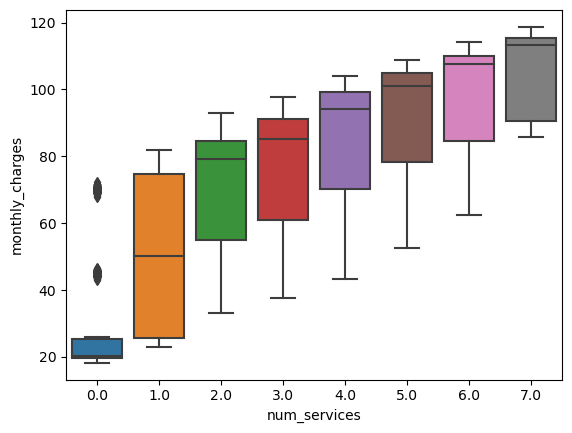

In [39]:
sns.boxplot(data=df, x='num_services', y='monthly_charges');

As the number of services increases, so does a customer's monthly charge.

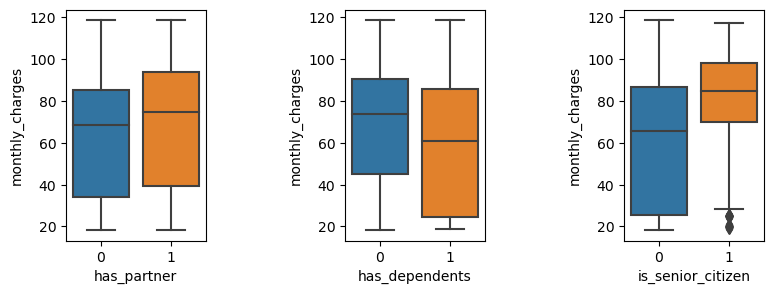

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
fig.subplots_adjust(wspace=1)
sns.boxplot(data=df, x='has_partner', y='monthly_charges', ax=ax[0]);
sns.boxplot(data=df, x='has_dependents', y='monthly_charges', ax=ax[1]);
sns.boxplot(data=df, x='is_senior_citizen', y='monthly_charges', ax=ax[2]);

The monthly charge does not have a significant change depending on if the customer has a partner or has dependents, but monthly charges appaears to have more variability for senior citizens, running higher on average than non-senior citizens.

## Model Preparation

Next, I prepare the models. I start by extracting the year and month information from the `begin_date` column. I drop `customer_id`, `end_date`, `num_services`, and `begin_date`.

In [41]:
# remove unnecessary columns
df['begin_year'] = df['begin_date'].dt.year
df['begin_month'] = df['begin_date'].dt.month

df = df.drop(columns=['customer_id', 'end_date', 'num_services', 'begin_date'], axis=1)

In [42]:
# view correlations
df.corr(numeric_only=True)

,paperless_billing,monthly_charges,total_charges,has_ended,internet_security,internet_backup,internet_device_protection,internet_tech_support,internet_tv,internet_movies,is_senior_citizen,has_partner,has_dependents,has_multiple_lines,begin_year,begin_month
paperless_billing,1.000000,0.352150,0.158574,0.191825,-0.003636,0.126735,0.103797,0.037880,0.223841,0.211716,0.156530,-0.014877,-0.111377,0.163530,-0.019011,0.024053
monthly_charges,0.352150,1.000000,0.651174,0.193356,0.296594,0.441780,0.482692,0.338304,0.629603,0.627429,0.220173,0.096848,-0.113890,0.490434,-0.264251,-0.018072
total_charges,0.158574,0.651174,1.000000,-0.198324,0.411651,0.509226,0.521983,0.431883,0.514973,0.520122,0.103006,0.317504,0.062078,0.468504,-0.819539,-0.194289
has_ended,0.191825,0.193356,-0.198324,1.000000,-0.171226,-0.082255,-0.066160,-0.164674,0.063228,0.061382,0.150889,-0.150448,-0.164221,0.040102,0.291621,0.181417
internet_security,-0.003636,0.296594,0.411651,-0.171226,1.000000,0.283832,0.275438,0.354931,0.176207,0.187398,-0.038653,0.143106,0.080972,0.098108,-0.316448,-0.103943
internet_backup,0.126735,0.441780,0.509226,-0.082255,0.283832,1.000000,0.303546,0.294233,0.282106,0.274501,0.066572,0.141498,0.023671,0.202237,-0.359148,-0.073651
internet_device_protection,0.103797,0.482692,0.521983,-0.066160,0.275438,0.303546,1.000000,0.333313,0.390874,0.402111,0.059428,0.153786,0.013963,0.201137,-0.357400,-0.092586
internet_tech_support,0.037880,0.338304,0.431883,-0.164674,0.354931,0.294233,0.333313,1.000000,0.278070,0.279358,-0.060625,0.119999,0.063268,0.100571,-0.314811,-0.095653
internet_tv,0.223841,0.629603,0.514973,0.063228,0.176207,0.282106,0.390874,0.278070,1.000000,0.533094,0.105378,0.124666,-0.016558,0.257152,-0.284914,-0.059497
internet_movies,0.211716,0.627429,0.520122,0.061382,0.187398,0.274501,0.402111,0.279358,0.533094,1.000000,0.120176,0.117412,-0.039741,0.258751,-0.289747,-0.068723


There are no remaining columns that have high correlation with each other, so there's no need to remove any additional columns.

### Splitting Data

The data will be split: 60% for training, 20% for validation, and 20% for testing. The validation set will be used during hyperparameter tuning. After the final model is selected, the training set and validation sets will be combined for model fitting.

In [43]:
# separate features from the target
features = df.drop(columns=['has_ended'], axis=1)
target = df[['has_ended']]

In [44]:
STATE = 12345

# reserving 20% of the data for the test dataset
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=STATE
)

# splitting the 80% of the source dataset into the training dataset (60%) and validation dataset (20%)  
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=STATE
)

In [45]:
# checking sizes of datasets
full_len = len(df)

print(f'Size of training set: {len(features_train) / full_len:.3}%')
print(f'Size of validation set: {len(features_valid) / full_len:.3}%')
print(f'Size of testing set: {len(target_valid) / full_len:.3}%')

Size of training set: 0.6%
Size of validation set: 0.2%
Size of testing set: 0.2%


### Scaling Data

The values in `monthly_charges` and `total_charges` must be scaled so that a heavier weight isn't put on those features during model training.

In [46]:
# scale numeric values
numeric = ['monthly_charges', 'total_charges']

# use standard scaler and fit on training data
scaler = StandardScaler()
scaler.fit(features_train[numeric])

# scale all sets
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Model Tests
Four models will be tested: RandomForest, LogisticRegression, CatBoost, and LightGBM. AUC-ROC will be the primary metric to compare, and accuracy will be the secondary metric.

The class imbalance will be addressed within the model's parameters.

### Model 1: Logistic Regression

The first model used will be Logistic Regression. Categorical variables will need to be encoded. 

In [47]:
# define categorical columns
categorical = ['type', 'internet_type', 'gender', 'payment_method'] 

# create ColumnTransformer to encode columns
ct = ColumnTransformer(
    [('one-hot-encoder', OneHotEncoder(drop='first'), categorical)], remainder='passthrough')

# fit on training set
ct.fit(features_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('one-hot-encoder', OneHotEncoder(drop='first'),
                                 ['type', 'internet_type', 'gender',
                                  'payment_method'])])

In [48]:
# apply column transformer to training and validation sets
features_train_ohe = ct.transform(features_train)
features_valid_ohe = ct.transform(features_valid)

In [49]:
# empty dataframe to store model results
model_scores = pd.DataFrame(columns=['model', 'auc_roc', 'accuracy'])

In [50]:
# create and fit model
lr_model = LogisticRegression(random_state=STATE, solver='liblinear', class_weight='balanced')
lr_model.fit(features_train_ohe, target_train.values.ravel())

# predict probs
res_valid = lr_model.predict(features_valid_ohe)
proba_valid = lr_model.predict_proba(features_valid_ohe)
proba_one_valid = proba_valid[:, 1]

# calculate AUC-ROC and accuracy
roc_auc = roc_auc_score(target_valid, proba_one_valid)
acc = accuracy_score(target_valid, res_valid)

print(f'AUC_ROC: {roc_auc}')
print(f'ACCURACY: {acc}')

AUC_ROC: 0.8232493132457722
ACCURACY: 0.7430801987224982


In [51]:
# add model to dataframe
model_scores.loc[len(model_scores.index)] = ['Logistic Regression', roc_auc, acc]

### Model 2: Random Forest

The second model to test will be Random Forest. I will use the OrdinalEncoder to encode its columns.

In [52]:
# encode data
encoder = OrdinalEncoder()

# create copies
features_train_encoded = features_train.copy()
features_valid_encoded = features_valid.copy()
features_test_encoded = features_test.copy()

# only fit encoder on the training set
encoder.fit(features_train_encoded[categorical])

# transform training and validation sets
features_train_encoded[categorical] = encoder.transform(features_train[categorical].astype('str'))
features_valid_encoded[categorical] = encoder.transform(features_valid_encoded[categorical].astype('str'))
features_test_encoded[categorical] = encoder.transform(features_test_encoded[categorical].astype('str'))

In [53]:
%%time

# create random forest model
rf_model = RandomForestClassifier(random_state=STATE, class_weight='balanced')

# use grid search for hyperparameter tuning
param_grid = { 
    'n_estimators': [40, 80, 120],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8],
    'criterion' :['gini', 'entropy']
}

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
CV_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5,
                     scoring=scoring, refit="AUC", return_train_score=True)
CV_rf.fit(features_train_encoded, target_train.values.ravel())

CPU times: user 49.2 s, sys: 133 ms, total: 49.3 s
Wall time: 49.5 s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12345),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [40, 80, 120]},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [54]:
# view best hyperparameters
CV_rf.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 120}

In [55]:
# predict probs
res_valid = CV_rf.predict(features_valid_encoded)
proba_valid = CV_rf.predict_proba(features_valid_encoded)
proba_one_valid = proba_valid[:, 1]

# calculate AUC-ROC and accuracy
roc_auc = roc_auc_score(target_valid, proba_one_valid)
acc = accuracy_score(target_valid, res_valid)

print(f'AUC_ROC: {roc_auc}')
print(f'ACCURACY: {acc}')

AUC_ROC: 0.8600389518413598
ACCURACY: 0.7778566359119943


In [56]:
# add model to dataframe
model_scores.loc[len(model_scores.index)] = ['Random Forest', roc_auc, acc]

### Model 3: CatBoost

In [57]:
%%time 

cb_model = CatBoostClassifier(random_seed=STATE, auto_class_weights='Balanced')

param_grid = {'depth': [5, 6, 7],
              'learning_rate' : [0.04, 0.05, 0.06, 0.08, 0.1],
              'iterations'    : [140, 150, 160, 170, 180, 190, 200]
             }

CV_cb = GridSearchCV(estimator=cb_model, param_grid=param_grid, cv=5, scoring='roc_auc')
CV_cb.fit(features_train, target_train, cat_features=categorical, verbose=0)

CPU times: user 4min 54s, sys: 2min 19s, total: 7min 13s
Wall time: 2min 47s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x147d747c0>,
             param_grid={'depth': [5, 6, 7],
                         'iterations': [140, 150, 160, 170, 180, 190, 200],
                         'learning_rate': [0.04, 0.05, 0.06, 0.08, 0.1]},
             scoring='roc_auc')

In [58]:
cb_best_params = CV_cb.best_params_

cb_depth = cb_best_params['depth']
cb_iterations = cb_best_params['iterations']
cb_rate = cb_best_params['learning_rate']

In [59]:
cb_best_params

{'depth': 6, 'iterations': 200, 'learning_rate': 0.1}

In [60]:
# predict probs
res_valid = CV_cb.predict(features_valid)
proba_valid = CV_cb.predict_proba(features_valid)
proba_one_valid = proba_valid[:, 1]

# calculate AUC-ROC and accuracy
roc_auc = roc_auc_score(target_valid, proba_one_valid)
acc = accuracy_score(target_valid, res_valid)

print(f'AUC_ROC: {roc_auc}')
print(f'ACCURACY: {acc}')

AUC_ROC: 0.8943256931925487
ACCURACY: 0.8232789212207239


In [61]:
# add model to dataframe
model_scores.loc[len(model_scores.index)] = ['CatBoost', roc_auc, acc]

### Model 4: LightGBM

In [62]:
# address categorical features
features_train_cat = features_train.copy()
features_valid_cat = features_valid.copy()
features_test_cat = features_test.copy()

for col in categorical:
    features_train_cat[col] = features_train_cat[col].astype('category')
    features_valid_cat[col] = features_valid_cat[col].astype('category')
    features_test_cat[col] = features_test_cat[col].astype('category')

In [63]:
# view class imbalance to set weight for LGBM
target_train.value_counts()

has_ended
0            3088
1            1137
dtype: int64

In [64]:
%%time

# weight = number of negative samples / number of positive samples
weight = 3088 / 1137

# create LGBM model
lgbm_model = LGBMClassifier(random_state=STATE, scale_pos_weight=3)

# use grid search for hyperparameter tuning
param_grid = { 
    'num_leaves': [20, 25, 30, 40, 50],
    'max_depth': [5, 6, 7, 8],
    'n_estimators' : [110, 120, 130, 140]
}

CV_lgbm = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=5, scoring='roc_auc')
CV_lgbm.fit(features_train_cat, target_train.values.ravel())

CPU times: user 1min 2s, sys: 1min 31s, total: 2min 34s
Wall time: 1min 50s


GridSearchCV(cv=5,
             estimator=LGBMClassifier(random_state=12345, scale_pos_weight=3),
             param_grid={'max_depth': [5, 6, 7, 8],
                         'n_estimators': [110, 120, 130, 140],
                         'num_leaves': [20, 25, 30, 40, 50]},
             scoring='roc_auc')

In [65]:
lgbm_best_params = CV_lgbm.best_params_

lgbm_max_depth = lgbm_best_params['max_depth']
lgbm_n_estimators = lgbm_best_params['n_estimators']
lgbm_num_leaves = lgbm_best_params['num_leaves']

In [66]:
lgbm_best_params

{'max_depth': 7, 'n_estimators': 140, 'num_leaves': 30}

In [67]:
# predict probs
res_valid = CV_lgbm.predict(features_valid_cat)
proba_valid = CV_lgbm.predict_proba(features_valid_cat)
proba_one_valid = proba_valid[:, 1]

# calculate AUC-ROC and accuracy
roc_auc = roc_auc_score(target_valid, proba_one_valid)
acc = accuracy_score(target_valid, res_valid)

print(f'AUC_ROC: {roc_auc}')
print(f'ACCURACY: {acc}')

AUC_ROC: 0.9027572109193922
ACCURACY: 0.8537970191625266


In [68]:
# add model to dataframe
model_scores.loc[len(model_scores.index)] = ['LightGBM', roc_auc, acc]

## Model Selection

In [72]:
model_scores

,model,auc_roc,accuracy
0,Logistic Regression,0.823249,0.743080
1,Random Forest,0.860039,0.777857
2,CatBoost,0.894326,0.823279
3,LightGBM,0.902757,0.853797


All models have an AUC_ROC above 0.82 and an accuracy above 0.74. LightGBM performs the best with an AUC-ROC of 0.90 and an accuracy of 0.85, so it will be used for the final evaluation of the model.

## Final Evaluation

In [70]:
# combine training and validation sets for final training
combined_train = pd.concat([features_train_cat, features_valid_cat])
combined_target = pd.concat([target_train, target_valid])

lgbm = LGBMClassifier(random_state=STATE, scale_pos_weight=weight,
                      max_depth=lgbm_max_depth, n_estimators=lgbm_n_estimators,
                      num_leaves=lgbm_num_leaves)

lgbm.fit(combined_train, combined_target.values.ravel())

LGBMClassifier(max_depth=7, n_estimators=140, num_leaves=30, random_state=12345,
               scale_pos_weight=2.7159190853122253)

In [71]:
# predict probs
res_valid = lgbm.predict(features_test_cat)
proba_valid = lgbm.predict_proba(features_test_cat)
proba_one_valid = proba_valid[:, 1]

# calculate AUC-ROC and accuracy
roc_auc = roc_auc_score(target_test, proba_one_valid)
acc = accuracy_score(target_test, res_valid)

print(f'AUC_ROC: {roc_auc}')
print(f'ACCURACY: {acc}')

AUC_ROC: 0.9224453723390629
ACCURACY: 0.8658623136976579


## Conclusion

In [76]:
# display model weights
eli5.show_weights(lgbm)

Weight,Feature
0.2585,type
0.2469,total_charges
0.1441,monthly_charges
0.1051,begin_month
0.0796,begin_year
0.0672,internet_type
0.0153,payment_method
0.0107,paperless_billing
0.0103,internet_movies
0.0092,internet_tv


Some features are weighted much higher than others in terms of determining if a customer is going to churn. In particular, the type of subscription, total charges, monthly charges, when a customer starts their service, and the type of internet they have are the largest factors affecting the churn rate of the company.

# Initial Work Plan

## Clarifying Questions
To be completed during additional EDA:
* For customers that end their service, how many months do they tend to stay before leaving?
* Is there a trend for when customers tend to start their service?
* What is the distribution of current customers and customers that have ended their service?
* What are the earliest and latest dates in the dataset? 
* How is "Total Charges" calculated? Could this be used to figure out the number of months a client has stayed with the company?
* How does Monthly Charges relate to personal information - ie does monthly charge increase if the person has a partner? Has dependents?

## Steps

1. Load and preprocess the data: The column names in each dataset will be standardized (snake_case), columns with 2 values (ie Yes/No) will have their values changed to 1/0, datatypes will be updated, and the data will be merged on the customerID column - I will need to address null values that result from the merging.

2. EDA: Based on the above clarifying questions.

2. Feature engineering and column removal: I want to see if some of the columns are highly correlated with each other, which would indicate they contain redundant information and should be removed. I also want to create new columns, ie a `begin_year` column and a `has_ended_service` column (which will be the target column and is based on data in the `end_date` column). A `months_spent` column, indicating the number of months the client has had service, could also be helpful.

3. Scale and encode the data: The columns with float information will be scaled, and values with multiple values (ie `type` and `payment_method` will be one hot encoded.

4. Build the models: I want to try a few models, including RandomForest and LogisticRegression, CatBoost, LGBM. I will do a 60/20/20 split to get training/validation/testing datasets and use the validation dataset to choose the best model, then use the validation/testing dataset to evaluate the final model.

# Solution Report

#### What steps of the plan were performed and what steps were skipped (explain why)?
* Step 1: I completed data preprocessing and cleaning.
* Step 2: For EDA, I ended up not looking at when customers started their service because initially I removed the `begin_date` column from the training data. The final model revealed that the starting month/year are actually really important in determining if a customer churns, so it would be beneficial to do further analysis on this. I also did not look more in depth at the `total_charges` column, as my plan was initially to use it to figure out how long a client had stayed with the company. I was instead able to derive that information by looking at the starting date and ending date columns.
* Step 3: I completed feature engineering by creating `begin_year`, `begin_month`, and `has_ended` columns. I did not include the `months_spent` column in the final dataset, but I looked at it when analyzing customers who have churned.
* Step 4: I scaled the numeric data and encoded the data for the models that required it.
* Step 5: I completed model testing and evaluation.

#### What difficulties did you encounter and how did you manage to solve them?
At first, I wasn't getting the AUC-ROC score that I wanted despite doing extensive hyperparameter testing across my models (the highest AUC-ROC I was getting was 84.8%). This ended up being because I had dropped the `begin_date` column, as my models were having difficulty understanding the datetime format. To solve this problem, I created two new columns: `begin_month` and `begin_year`. My AUC-ROC scores skyrocketed with this improvement.

I had also never used Grid Search before this assignment - I was instead manually testing different hyperparameter combinations. I had to look at examples and in the documentation to understand it, but once I did, it made it very easy to tune hyperparameters.

#### What were some of the key steps to solving the task?

The data cleaning was the most important part - having clean, usable data was extremely important for this task. I created a few data visualizations when looking at monthly charges and how it was affected by personal factors/number of services, and that helped me understand the data. I think data visualizations help communicate results well, so I would have liked to do more.

Feature engineering was also key. Though my AUC-ROC score was okay without it, adding in `begin_year` and `begin_month` improved my model quality substancially. 

Last, I used the eli5 library (which I had never used before) to display the final model weights. This made it easy to see which factors were weighted the most in the model and brought the problem back to the business context of what the business could do to improve customer retention.

#### What is your final model and what quality score does it have?

The final model I chose was LightGBM. On the final test set, it resulted in an AUC-ROC of 0.922 and an accuracy of 0.865.